In [3]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data Ser...

In [8]:
%load ../isopy/isopy.py
import numpy as np
import xarray as xr
from scipy import interpolate

def compute_iso(data, iso, lev, d_or_t):

    """ compute the depth of some isopycnal/isotherm.
    
    Parameters:
    ----------------
    
    data: the input variable (Temperature, Density),
        array_like (3D), shape (N, M, L).
    iso: the objective isosurface layer,
        float.
    lev: the vertical depth,
        array_like (1D), shape (N).
    d_or_t: input d or t for density or temperature (lowercase)
        string
        
    Returns:
    ----------------
    
    var_iso: the output variable,
        array_like (2D), shape (M, L).
        
    """
    size = data.shape
    L = size[2]
    M = size[1]
    N = size[0] #this should be the same length as lev
    
    #check that the input data is in the for depth lat lon (or depth lon lat)
    if len(lev) ~= N:
        print('Error: either data input variable does not have depth as dimension 0, or lev variable is not same length as depth')
        break
    if d_or_t ~= 'd' or 't':
        print('Is this density or temperature?')
        break
    var_iso = np.zeros((M, L)) # define the output var
    var_iso[:, :] = np.nan # NaN fill to avoid any later computation errors with zeros

    for i in np.arange(L): #loop through dimension 1
        for j in np.arange(M): #loop through dimension 2

                data_prof = data[:, j, i] #select one profile
                if d_or_t == 'd':
                    id1 = np.where(data_prof < iso)
                    if np.size(id1) > 0 and np.size(id1) < len(z):

                        var1 = data_prof[id1[0][-1]]
                        var2 = data_prof[id1[0][-1] + 1]

                    if var1 < var2:
                        func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                        var_iso[j, i] = func(iso)

                else：
                    id1 = np.where(data_prof > iso)
                        
                    if np.size(id1) > 0 and np.size(id1) < len(z):

                        var1 = data_prof[id1[0][-1]]
                        var2 = data_prof[id1[0][-1] + 1]

                    if var1 > var2:
                        func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                        var_iso[j, i] = func(iso)

    return var_iso


def iso_average(data, iso, lev):
    
    """ compute vertical average above the objective isopycnal layer
    
    Parameters:
    ----------------
    
    data: the input variable (Temperature, Salinity, Density ...),
        array_like (3D), shape (N, M, L).
    iso: the objective isopycnal layer,
        float.
    lev: the vertical depth,
        array_like (1D), shape (N)
        
    Returns:
    ----------------
    
    var_ave: the output variable,
        array_like (2D), shape (M, L).
    
    """
    
    return var_ave

SyntaxError: invalid syntax (<ipython-input-8-0a89d7d37b38>, line 35)

In [7]:
%%time

pden = ds.pden #.chunk(chunks={'lat' : 30, 'lon' : 30})
z = pden.lev.values
iso = [24]

#for t in np.arange(size[0]):
for t in np.arange(1):
    data = pden[0, :, :].values
    dep_iso = compute_iso(data, iso, z, 'f')
    #print(str(pden.time[t].values))
    
#ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])


TypeError: compute_iso() takes 3 positional arguments but 4 were given

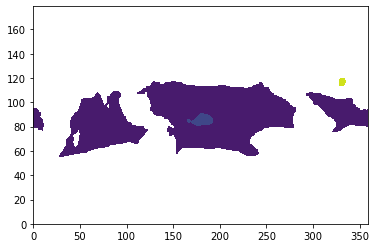

In [6]:
plt.contourf(dep_iso, np.arange(0, 400, 10))